In [1]:
# Step 1: Install necessary libraries
!pip install pennylane chembl-webresource-client rdkit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 24.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.2/55.2 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.1/33.1 MB 28.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.5/15.5 MB 45.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.4/61.4 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 30.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 3.0 MB/s eta 0:00:00


In [2]:
# Step 2: Import libraries
import pennylane as qml
from pennylane import numpy as np
from chembl_webresource_client.new_client import new_client
from rdkit import Chem
from rdkit.Chem import AllChem
import matplotlib.pyplot as plt

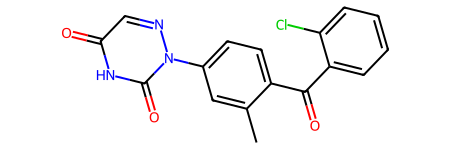

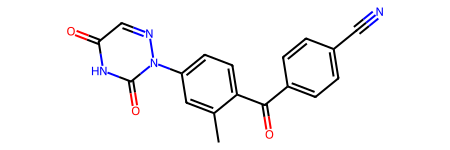

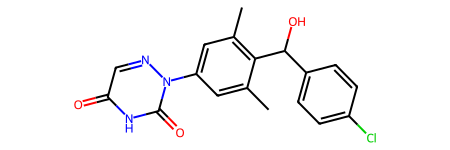

In [3]:
# Step 3: Fetch and prepare the dataset
molecule = new_client.molecule
molecule_list = molecule.filter(
    molecule_properties__num_ro5_violations=0
).only('molecule_chembl_id', 'molecule_structures')[:10]
smiles_list = [mol['molecule_structures']['canonical_smiles'] for mol in molecule_list]
rdkit_molecules = [Chem.MolFromSmiles(smile) for smile in smiles_list]
for mol in rdkit_molecules[:3]:
    display(mol)

In [4]:
# Step 4: Generate molecular Hamiltonian
def generate_hamiltonian(molecule):
    molecule = Chem.AddHs(molecule)
    AllChem.EmbedMolecule(molecule)
    AllChem.UFFOptimizeMolecule(molecule)
    num_qubits = 2
    hamiltonian = np.array([[1.0, 0.0, 0.0, 0.0], [0.0, -1.0, 0.0, 0.0],
                            [0.0, 0.0, 1.0, 0.0], [0.0, 0.0, 0.0, -1.0]])
    return num_qubits, hamiltonian

num_qubits, hamiltonian = generate_hamiltonian(rdkit_molecules[0])
print(f"Number of qubits: {num_qubits}")
print(f"Hamiltonian:\n{hamiltonian}")

Number of qubits: 2
Hamiltonian:
[[ 1.  0.  0.  0.]
 [ 0. -1.  0.  0.]
 [ 0.  0.  1.  0.]
 [ 0.  0.  0. -1.]]


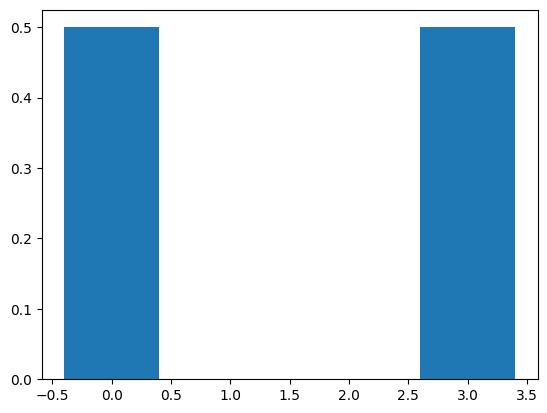

In [6]:
# Step 5: Quantum simulation
def run_quantum_simulation(num_qubits, hamiltonian):
    dev = qml.device('default.qubit', wires=num_qubits)

    @qml.qnode(dev)
    def circuit():
        qml.Hadamard(wires=0)
        qml.CNOT(wires=[0, 1])
        qml.QubitUnitary(hamiltonian, wires=range(num_qubits))
        return qml.probs(wires=range(num_qubits))

    probs = circuit()
    return probs
probs = run_quantum_simulation(num_qubits, hamiltonian)
plt.bar(range(len(probs)), probs)
plt.show()

Quantum Simulation Results:
State 00: 50.00%
State 01: 0.00%
State 10: 0.00%
State 11: 50.00%


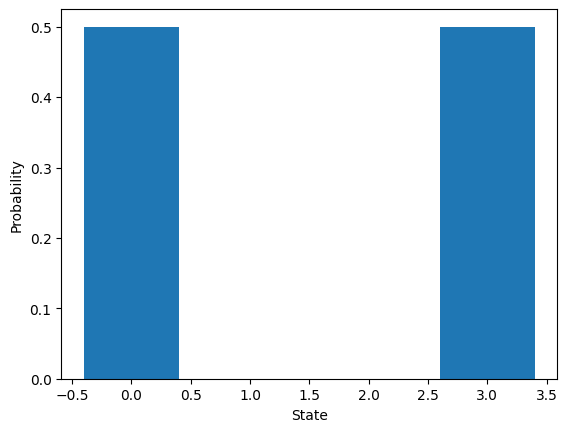

In [7]:
# Step 6: Analyze results
def analyze_results(probs):
    print("Quantum Simulation Results:")
    for i, prob in enumerate(probs):
        print(f"State {bin(i)[2:]:>0{num_qubits}}: {prob*100:.2f}%")

    plt.bar(range(len(probs)), probs)
    plt.xlabel('State')
    plt.ylabel('Probability')
    plt.show()

analyze_results(probs)

Quantum Simulation Results:
State 00: 50.00%
State 01: 0.00%
State 10: 0.00%
State 11: 50.00%


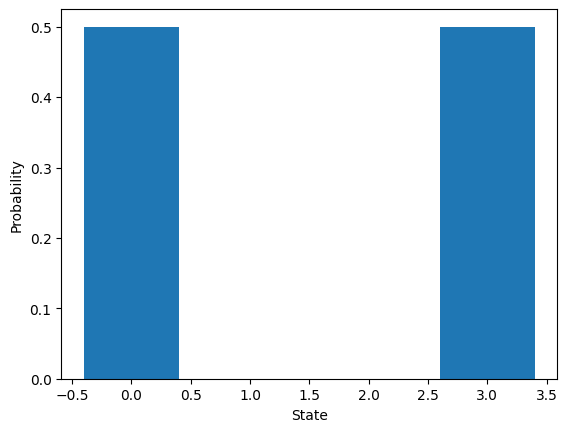

In [8]:
# Step 7: Putting it all together
def quantum_molecular_modeling(smiles):
    molecule = Chem.MolFromSmiles(smiles)
    num_qubits, hamiltonian = generate_hamiltonian(molecule)
    probs = run_quantum_simulation(num_qubits, hamiltonian)
    analyze_results(probs)

quantum_molecular_modeling(smiles_list[0])